
# <span style="color:rgb(213,80,0)">Representation of diffusion MRI data: color coding, glyphs, tractography and beyond</span>

In the previous chapters we have focused on voxel\-wise quantitative information extracted from diffusion volumes, but we have more or less neglected orientation and tract\-based information (except for the color\-coded maps in DTI). In this chapter we will introduce the advanced graphics capabilities of <samp>DMRIMatlab</samp>, both for DTI and the non\-Gaussian representations presented in the previous chapter. Our <samp>DMRIMatlab</samp> bases all these representations in the same function <samp>plotdmri3d</samp>:

<pre>
help plotdmri3d
</pre>

As you can see, it has plenty of options that can result somehow overwhelming. However, we will try to illustrate some usual use cases.


 ***TO DO:*** Clear all variables and figures to start from zero (*Ctrl+ENTER*):


In [1]:
addpath('..');
setup__DMRIMatlab_toolbox;
clear;
close('all');


















You're running version 1.0 of the toolbox under octave 10.30
Using graphics toolkit: qt




















For this chapter we will use an *ad hoc* data set that, as opposed to those we have used before:

-  Comprises all slices of the acquisition, so that its resolution is the same for all axes.
-  Contains pre\-processed data instead of raw attenuation signals.

In [2]:
whos -file test_data4
load test_data4


Variables in the file test_data4:

variables in scope: test_data4

  Attr   Name         Size                     Bytes  Class
  ====   ====         ====                     =====  ===== 
         bi         253x1                       2024  double
         dti        110x110x66x6            38332800  double
         gi         253x3                       6072  double
         ijk2xyz      4x4                        128  double
         labs       110x110x66                798600  uint8
         lpar       110x110x66               6388800  double
         lperp      110x110x66               6388800  double
         mask       110x110x66                798600  logical
         shodf      110x110x66x28          178886400  double

Total is 30347828 elements using 231602224 bytes





Note we have a variable <samp>dti</samp> with the tensor volume computed for the subject. Besides, <samp>lpar</samp>, <samp>lperp</samp> are the micro\-structure parameters of MiSFIT's convolution kernel, and <samp>shodf</samp> are the SH coefficients of MiSFIT's ODF. The variable <samp>ijk2xyz</samp> is used to relate the orientations of the raster scan of the voxels with the actual anatomical orientations of the subject (necessary to properly interpret voxel\-wise orientations). Besides, we have a variable <samp>labs</samp> which contains manual segmentations of certain white matter regions.

## 1\- Represent image slices in 3\-D

The function <samp>plotdmri3d</samp> is meant to be acumulative, i.e., several elements will be added to the same figure with each call.


A "slice" is a 2\-D section from of a 3\-D volume. One limitation of <samp>plotdmri3d</samp> is that it can only represent slices directly taken from the raster scan arrangement of the volume (no oblique slices are allowed). We can define an axial slice by fixing a constant value of the third index:


In [3]:
[szI,szJ,szK] = size(mask); % The field of view
i1 = [1,szI]; % All the FOV for the 1st index
j1 = [1,szJ]; % All the FOV for the 2nd index
k1 = [round(szK/2),round(szK/2)]; % Just the central slice


A sagittal slice means the first index is kept constant:


In [4]:
i2 = [round(szI/2),round(szI/2)];
j2 = [1,szJ];
k2 = [1,szK];


A coronal slice means the second index is kept constant:


In [5]:
i3 = [1,szI];
j3 = [round(szJ/2),round(szJ/2)];
k3 = [1,szK];


As you can see, slices are defined as four "window corners" plus a singleton dimension. The function <samp>plotdmri3d</samp> is primarily meant to represent orientation information, so that its basic input is a SH volume. But, what if I am only interested in DTI, so I don't have any SH volume? Well, good news is that you can easily translate a DTI volume to a SH\-compatible volume just like:


In [6]:
dtiSH = hot2sh( dti, 'mask', mask );


And now we are ready to plot the slices:


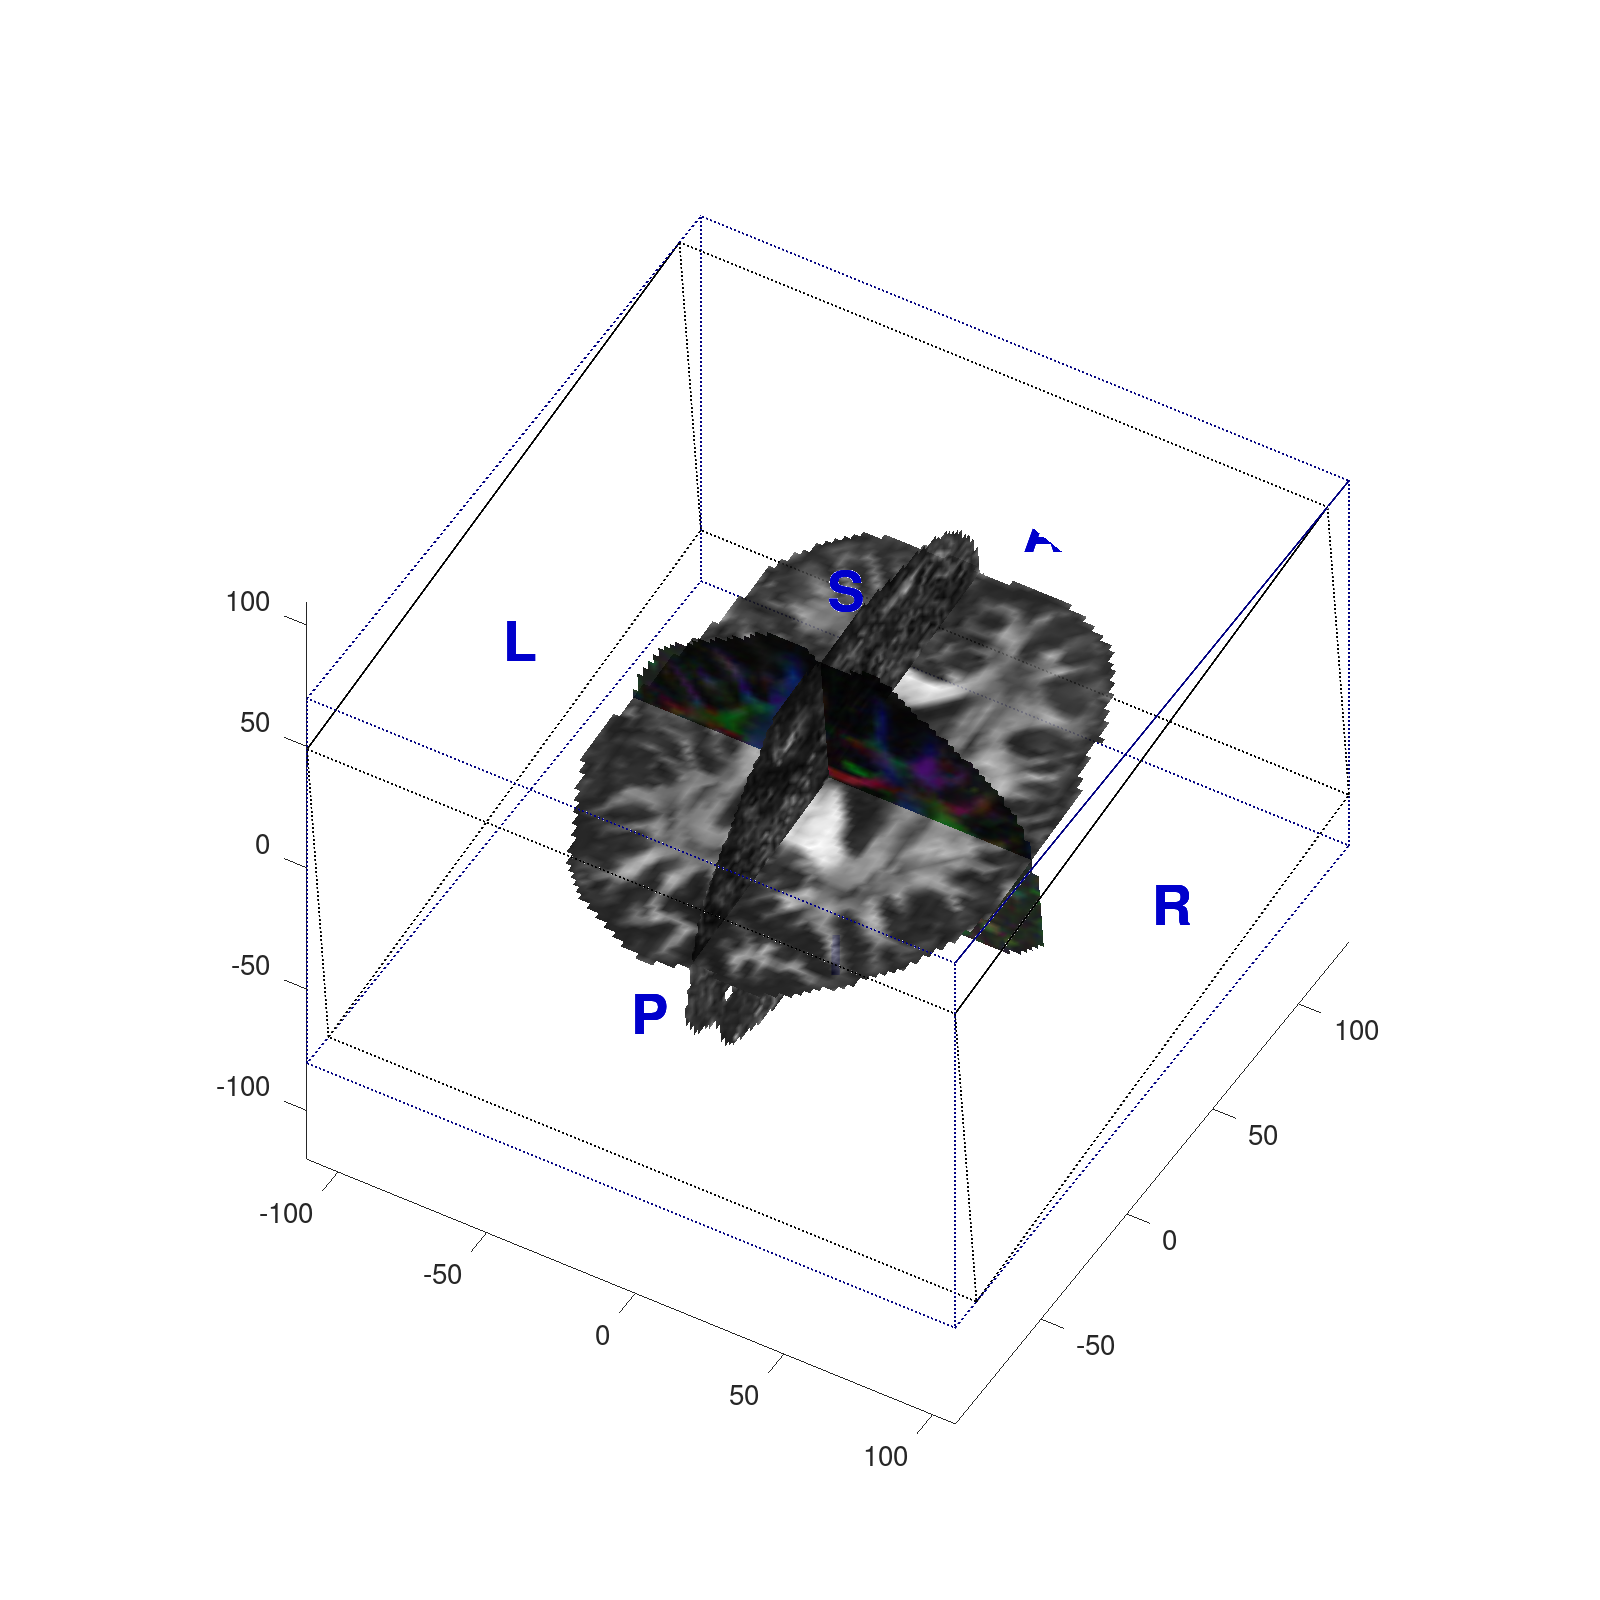

In [7]:
close(figure(1));
hf1 = figure(1);
set(hf1,'Position',[1,1,800,800]);
% Get the current axes of the newly created figure:
ha = axes(hf1);
% The sagittal slice. At the very least, we need to pass the SH volume and
% the variables describing the slice. We will use the reference dtiSH
% volume also as the image to plot the background. For the axial slice we
% will plot the FA
plotdmri3d( dtiSH, i1, j1, k1, ...
    'mask', mask, ... % This makes non-masked voxels transparent
    'origin', ijk2xyz(1:3,4), ... % The anatomical (rea-world units) origin
    'direction', ijk2xyz(1:3,1:3), ... % The real-worl orientation
    'space', 'RAS', ... % Anatomical space
    'ha', ha, ... % Don't forget to tell the function where to plot!!!
    'glyphs', false, ... % Dont's show voxel-wise orientation glyphs
    'bgimage', 'fa', ... % This slice will be an FA map
    'bgalpha', 0.9 ... % Slice transparency
    );
% For the sagittal slice we will represent a volume "manually computed"
% outside the function, for example Westin's "planar coefficient":
[~,~,~,l1,l2,l3] = dti2spectrum( dti, 'mask', mask );
cp = spectrum2scalar( l1, l2, l3, 'scalar', 'cp', 'mask', mask );
fa = spectrum2scalar( l1, l2, l3, 'scalar', 'fa', 'mask', mask ); % To be used later on
plotdmri3d( dtiSH, i2, j2, k2, ...
    'mask', mask, ... % This makes non-masked voxels transparent
    'origin', ijk2xyz(1:3,4), ... % The anatomical (rea-world units) origin
    'direction', ijk2xyz(1:3,1:3), ... % The real-worl orientation
    'space', 'RAS', ... % Anatomical space
    'ha', ha, ... % Don't forget to tell the function where to plot!!!
    'glyphs', false, ... % Dont's show voxel-wise orientation glyphs
    'bgimage', cp, ... % This slice will be an CP map
    'bgalpha', 0.9 ... % Slice transparency
    );
% And for the coronal slice we will represent a color-code
plotdmri3d( dtiSH, i3, j3, k3, ...
    'mask', mask, ... % This makes non-masked voxels transparent
    'origin', ijk2xyz(1:3,4), ... % The anatomical (real-world units) origin
    'direction', ijk2xyz(1:3,1:3), ... % The real-world orientation
    'space', 'RAS', ... % Anatomical space
    'ha', ha, ... % Don't forget to tell the function where to plot!!!
    'glyphs', false, ... % Dont's show voxel-wise orientation glyphs
    'bgimage', 'color', ... % This slice will be a color-code map
    'bgalpha', 0.9 ... % Slice transparency
    );
% Scale the axis so that they represent real-world dimensions:
axis('equal');
% Rotate:
view(30,45);
% Allow manual rotation (drag the mouse):
rotate3d('on');


***QUIZ:***

-  *What is the size of the matrix ijk2xyz? What does each part of the matrix represent?*
-  *You can see two different "bounding boxes" in the picture, one in blue the other in black. Can you guess what each of these boxes represent?*
## 2\- Represent orientation glyphs

In the  previous chapter we have mentioned that advanced diffusion representations are able to disentangle complex micro\-structural arrangements such as fibers crossing, bending or kissing. However, this capability is by no means evident from the RTxP maps, which are otherwise qualitatively similar to any scalar map derived from DTI. Let's demonstrate that MiSFIT is actually able to resolve fiber crossings by representing the variable <samp>shodf</samp> previously loaded:


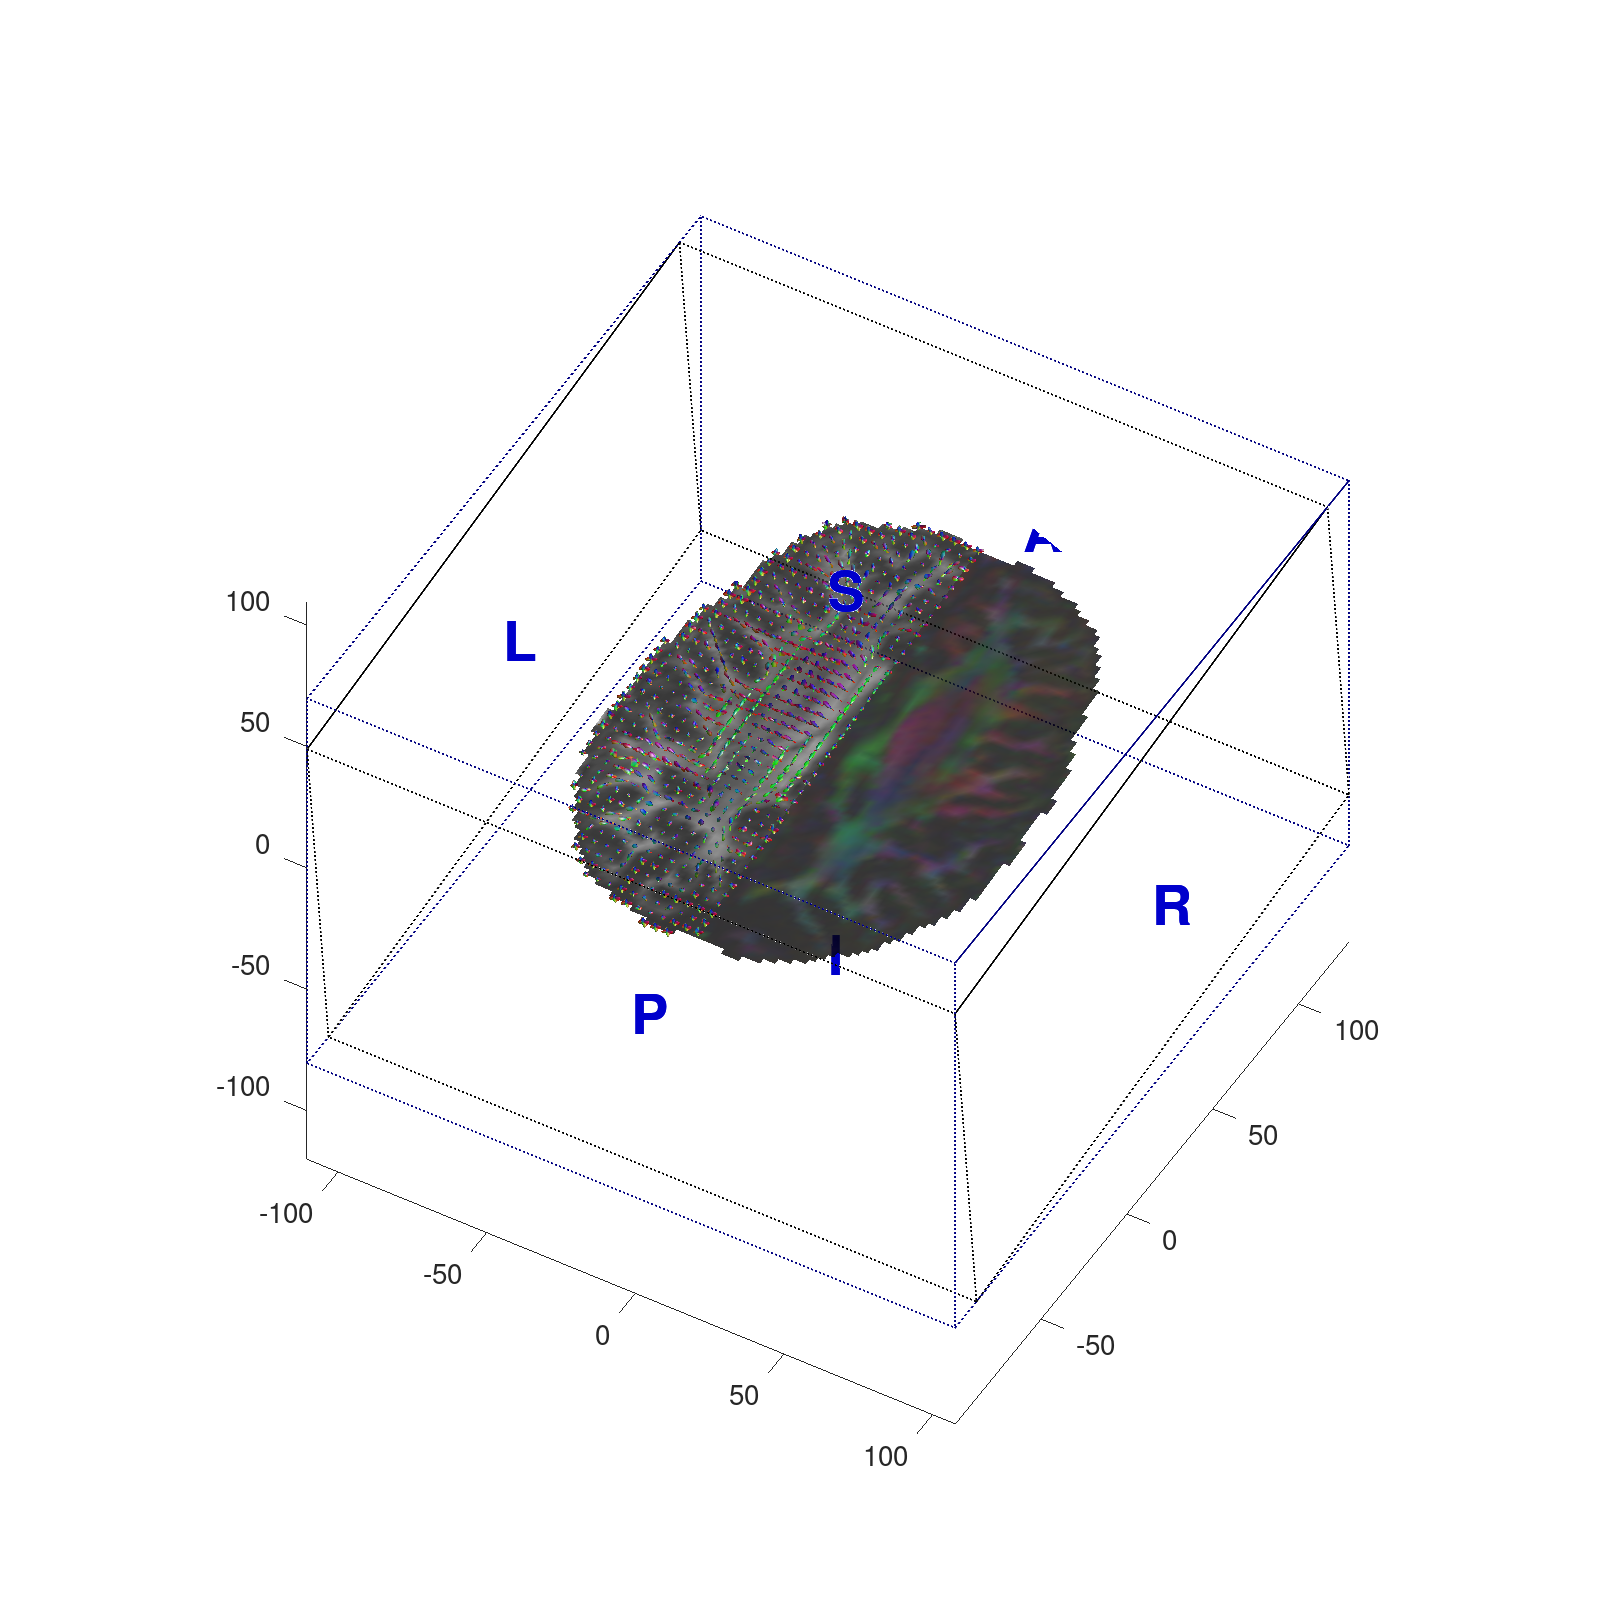

In [8]:
close(figure(2));
hf2 = figure(2);
set(hf2,'Position',[1,1,800,800]);
% Get the current axes of the newly created figure:
ha = axes(hf2);
% We will show just an axial slice (hope you have a decent graphics card).
% Half the slice will show just DTI-bsed color code:
i1 = [1,floor(szI/2)];
j1 = [1,szJ];
k1 = [round(szK/2),round(szK/2)] + 5; % Move several pixels upwards
% The other half will show a background with orientation glyphs overimposed
% to the FA map:
i2 = [floor(szI/2),szI];
j2 = j1;
k2 = k1; % Move several pixels upwards
% The first half is the same as in the previous image:
plotdmri3d( dtiSH, i1, j1, k1, ...
    'mask', mask, ... % This makes non-masked voxels transparent
    'origin', ijk2xyz(1:3,4), ... % The anatomical (rea-world units) origin
    'direction', ijk2xyz(1:3,1:3), ... % The real-worl orientation
    'space', 'RAS', ... % Anatomical space
    'ha', ha, ... % Don't forget to tell the function where to plot!!!
    'glyphs', false, ... % Dont's show voxel-wise orientation glyphs
    'bgimage', 'color', ... % This slice will be a color-code map
    'bgalpha', 0.8 ... % Slice transparency
    );
% The second half needs some more arguments. Besides, note that we are
% using MiSFIT-computed shodf as the reference volume to be able to resolve
% crossing fibers
plotdmri3d( shodf, i2, j2, k2, ...
    'mask', mask, ... % This makes non-masked voxels transparent
    'origin', ijk2xyz(1:3,4), ... % The anatomical (rea-world units) origin
    'direction', ijk2xyz(1:3,1:3), ... % The real-worl orientation
    'space', 'RAS', ... % Anatomical space
    'ha', ha, ... % Don't forget to tell the function where to plot!!!
    'bgimage', 'fa', ... % Used only for the background
    'bgsh', dtiSH, ... % Use the tensor representation for the background
    'bgalpha', 0.8, ... % Background transparency
    ... % THESE ARE THE NEW ARGUMENTS WE NEED:
    'glyphs', true, ... % We DO WANT glyphs!
    'glyphspc', [2;2;2], ... % Plot glyphs every two voxels at each direction
    'glyphsc', 2, ... % Scale applied to all glyphs
    'glyphscvar', 'ga' ... % Scale the glyphs depending on their anisotropy
    );
% Scale the axis so that they represent real-world dimensions:
axis('equal');
% Rotate:
view(30,45);
% Add some light effects to make things look cooler:
light
lighting(phong);
% Allow manual rotation (drag the mouse):
rotate3d('on');


***QUIZ:***

-  *The slice we have chosen contains a great part of the centrum semiovale, where many important fiber bundles are known to cross each other. If you have some expertise on neuroanatomy, you may try to identify some of them.*
-   *One important property of Spherical Harmonics is that they draw progressive refinements of the spherical signal with their successive degrees. You can easily "reduce" the representation given by* *<samp>shodf</samp>* *by keeping just its first few coefficients. In particular, try to do the following operations and re\-run the code substituting* *<samp>shodf</samp>* *with each resulting* *<samp>shodf_reduced</samp>**. What happens for L=2?*
<pre>
% This corresponds to SH up to order L=4:
shodf_reduced = shodf(:,:,:,1:15);
% This corresponds to SH up to order L=2:
shodf_reduced = shodf(:,:,:,1:6);
</pre>

***QUIZ:***


*Would you be able to draw a coronal slice with glyphs representing MiSFIT's ODFs?*

## 3\- Computing and representing tractographies

The highest level front\-end for the representation of diffusion MRI data is pobably tractography or fiber\-tracking. With this technique, one starts with a set of "seeds" or fiducial locations within the field of view of the image and traces streamlines following the main diffusion directions at each visited location until a stop criterion is met (this explanation is a heavy over\-simplification of the literature on fiber\-tracking, but it will serve for our purposes). To know what we are talking about, let's check the "labelmap" we have loaded with the test data in this chapter, i.e. the volume <samp>labs</samp>. It is just a volume with the same size as the diffusion data that contains integer values tagging certain regions of interest we have manually delineated within the white matter (*Ctrl+ENTER*):



ans =

  0  1  2  3  4  5  6  7







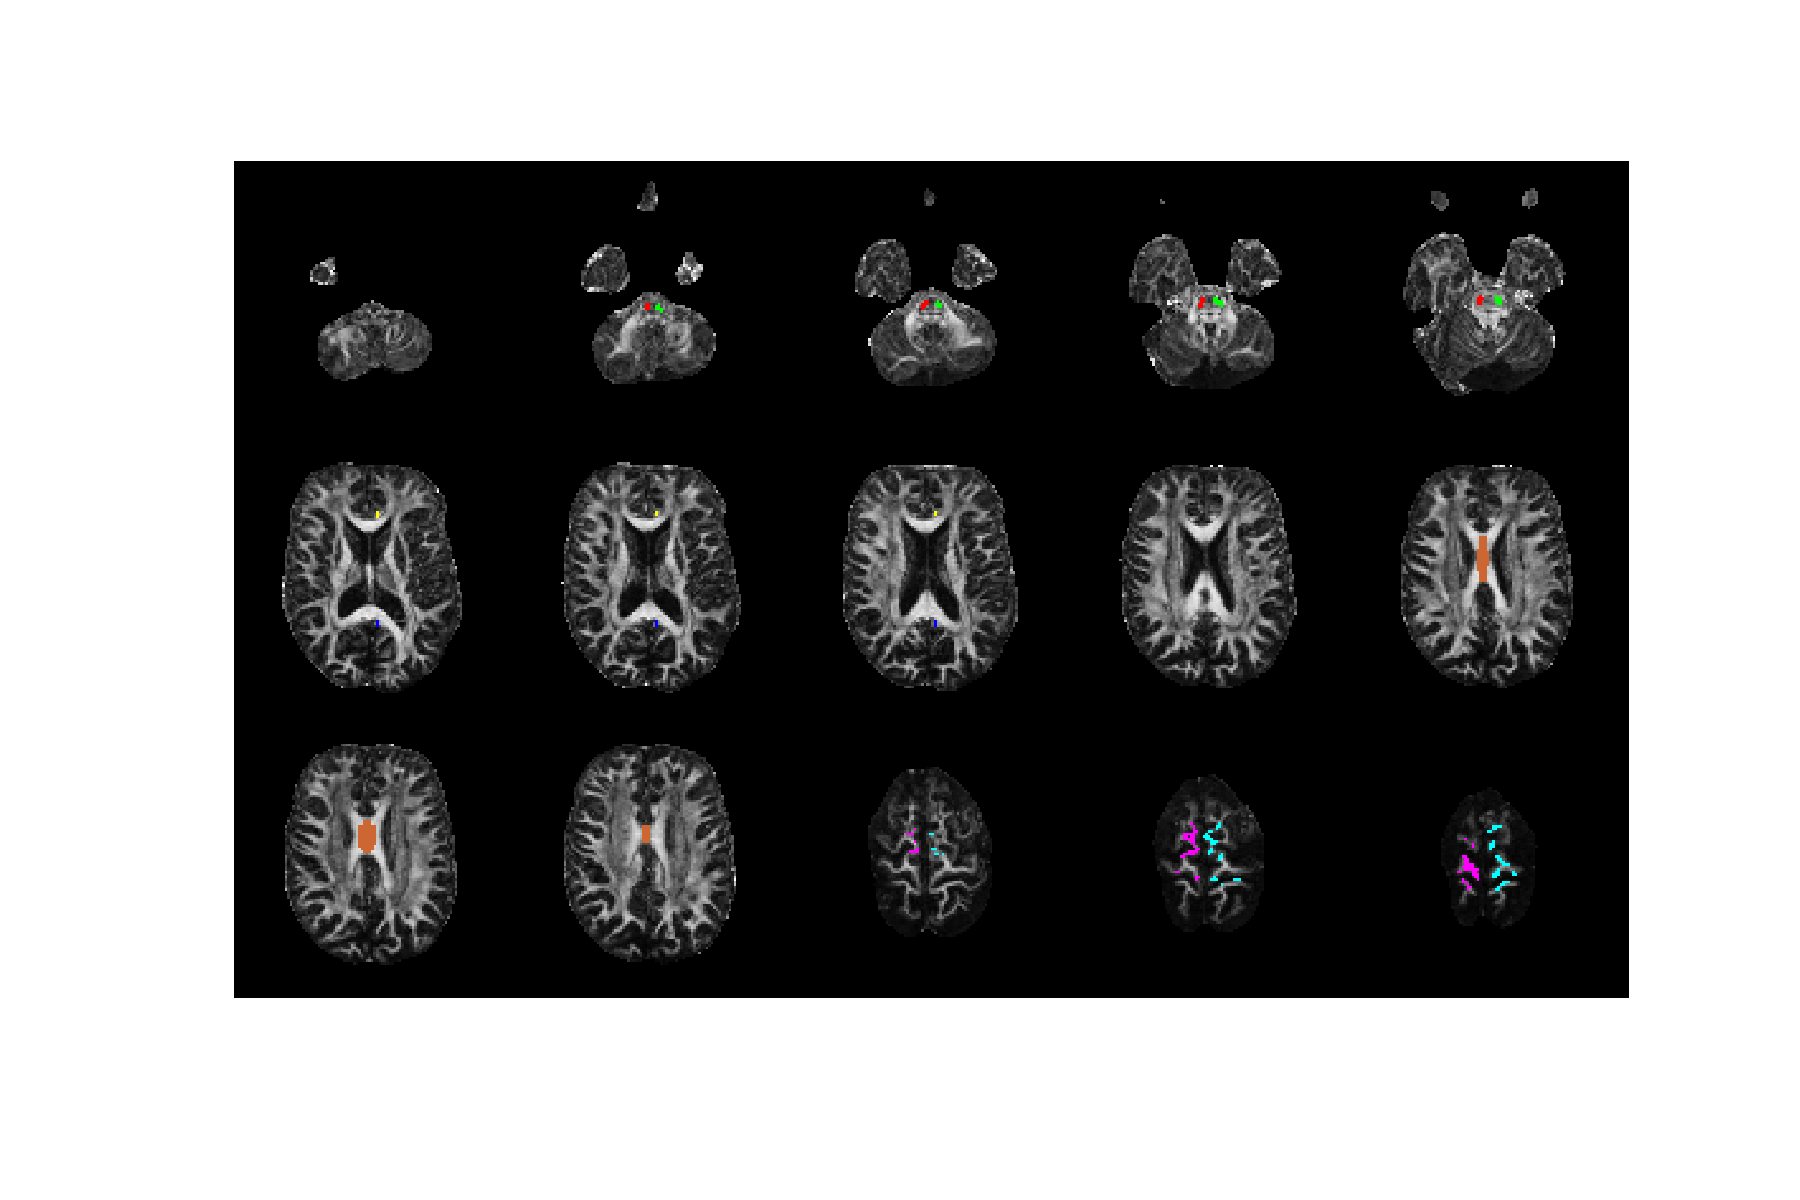

In [9]:
unique(labs)',
close(figure(3));
hf3 = figure(3);
set(hf3,'Position',[1,1,900,600]);
plotOverlaidLabelmap_demo1(labs,fa);


So the regions of interest are placed in:

-  Labels 1 (red) and 2 (green) are placed in the middle cerebellar peduncle, right and left hemispheres.
-  Label 3 (blue) is approximately placed over the posterior cingulum.
-  Label 4 (yellow) is approximately placed over the anterior cingulum.
-  Label 5 (orange) is placed right in the middle of the corpus callosum.
-  Labels 6 (magenta) and 7 (cyan) are placed in the uppermost part of the corticospinal tract.

These are just labelmaps tagged in the voxel space. To feed the tractography algorithm, we need to convert them to actual real\-world points with a function that takes a labelmap as an input and outputs acual seeds, hence its name is <samp>labelmap2seeds</samp>:


In [10]:
% The only mandatory input is the labelmap itself, but it is very likely
% that we will have to use some of its options:
seeds1 = labelmap2seeds( labs, ...
    'label', 1, ... % Select the region we are interested in (MCP, right)
    'nSeeds', 50, ... % How many seeds do we need?
    ... % NOTE THIS PARAMETER IS CRUCIAL!!!:
    'ijk2xyz', ijk2xyz ... % What is the actual spatial orientarion of the voxels?
    );
% Repeat for the other hemisphere:
seeds2 = labelmap2seeds( labs, ...
    'label', 2, ...
    'nSeeds', 50, ...
    'ijk2xyz', ijk2xyz );


Now we need a function that takes diffusion MRI data and outputs a tractography. Since our tractography will be by now DTI\-based, the function to use is called <samp>dti2tractography</samp>:


In [11]:
% The minimum required inputs are the DTI volume and
% the seeding poits, but it is likely that you will
% need to fix some of the optional parameters:
paths1 = dti2tractography( dti, seeds1, ...
    'mask', mask, ...
    ... % THIS PARAMETER IS AGAIN CRUCIAL!!!:
    'ijk2xyz', ijk2xyz );
% Repeat for the other hemisphere:
paths2 = dti2tractography( dti, seeds2, ...
    'mask', mask, ...
    ... % THIS PARAMETER IS AGAIN CRUCIAL!!!:
    'ijk2xyz', ijk2xyz );


You can check that the variables output by <samp>dti2tractography</samp> are so\-called "cell arrays", i.e abstract vectors each of whose positions can be more or less anyhthing:


In [12]:
class(paths1),
length(paths1),
size(paths1{13}),
size(paths1{71}),


ans = cell

ans = 100

ans =

   3   8


ans =

    3   60




In our case, <samp>paths1</samp> has 100 entries because we have used 100 seeding points to generate it (we passed '<samp>nSeeds</samp>', 100 when we called <samp>labelmap2seeds</samp>). Each of these entries is a $3\times N$ matrix, where the algorithm stacks the succesive <samp>x</samp>, <samp>y</samp> and <samp>z</samp> coordinates of the traced fibers (in real world coordinates). Hence, it suffices to use Matlab's plot3 command to draw these streamlines. But first, to give a little bit of context, we will show first axial, sagittal and coronal slices of the FA:


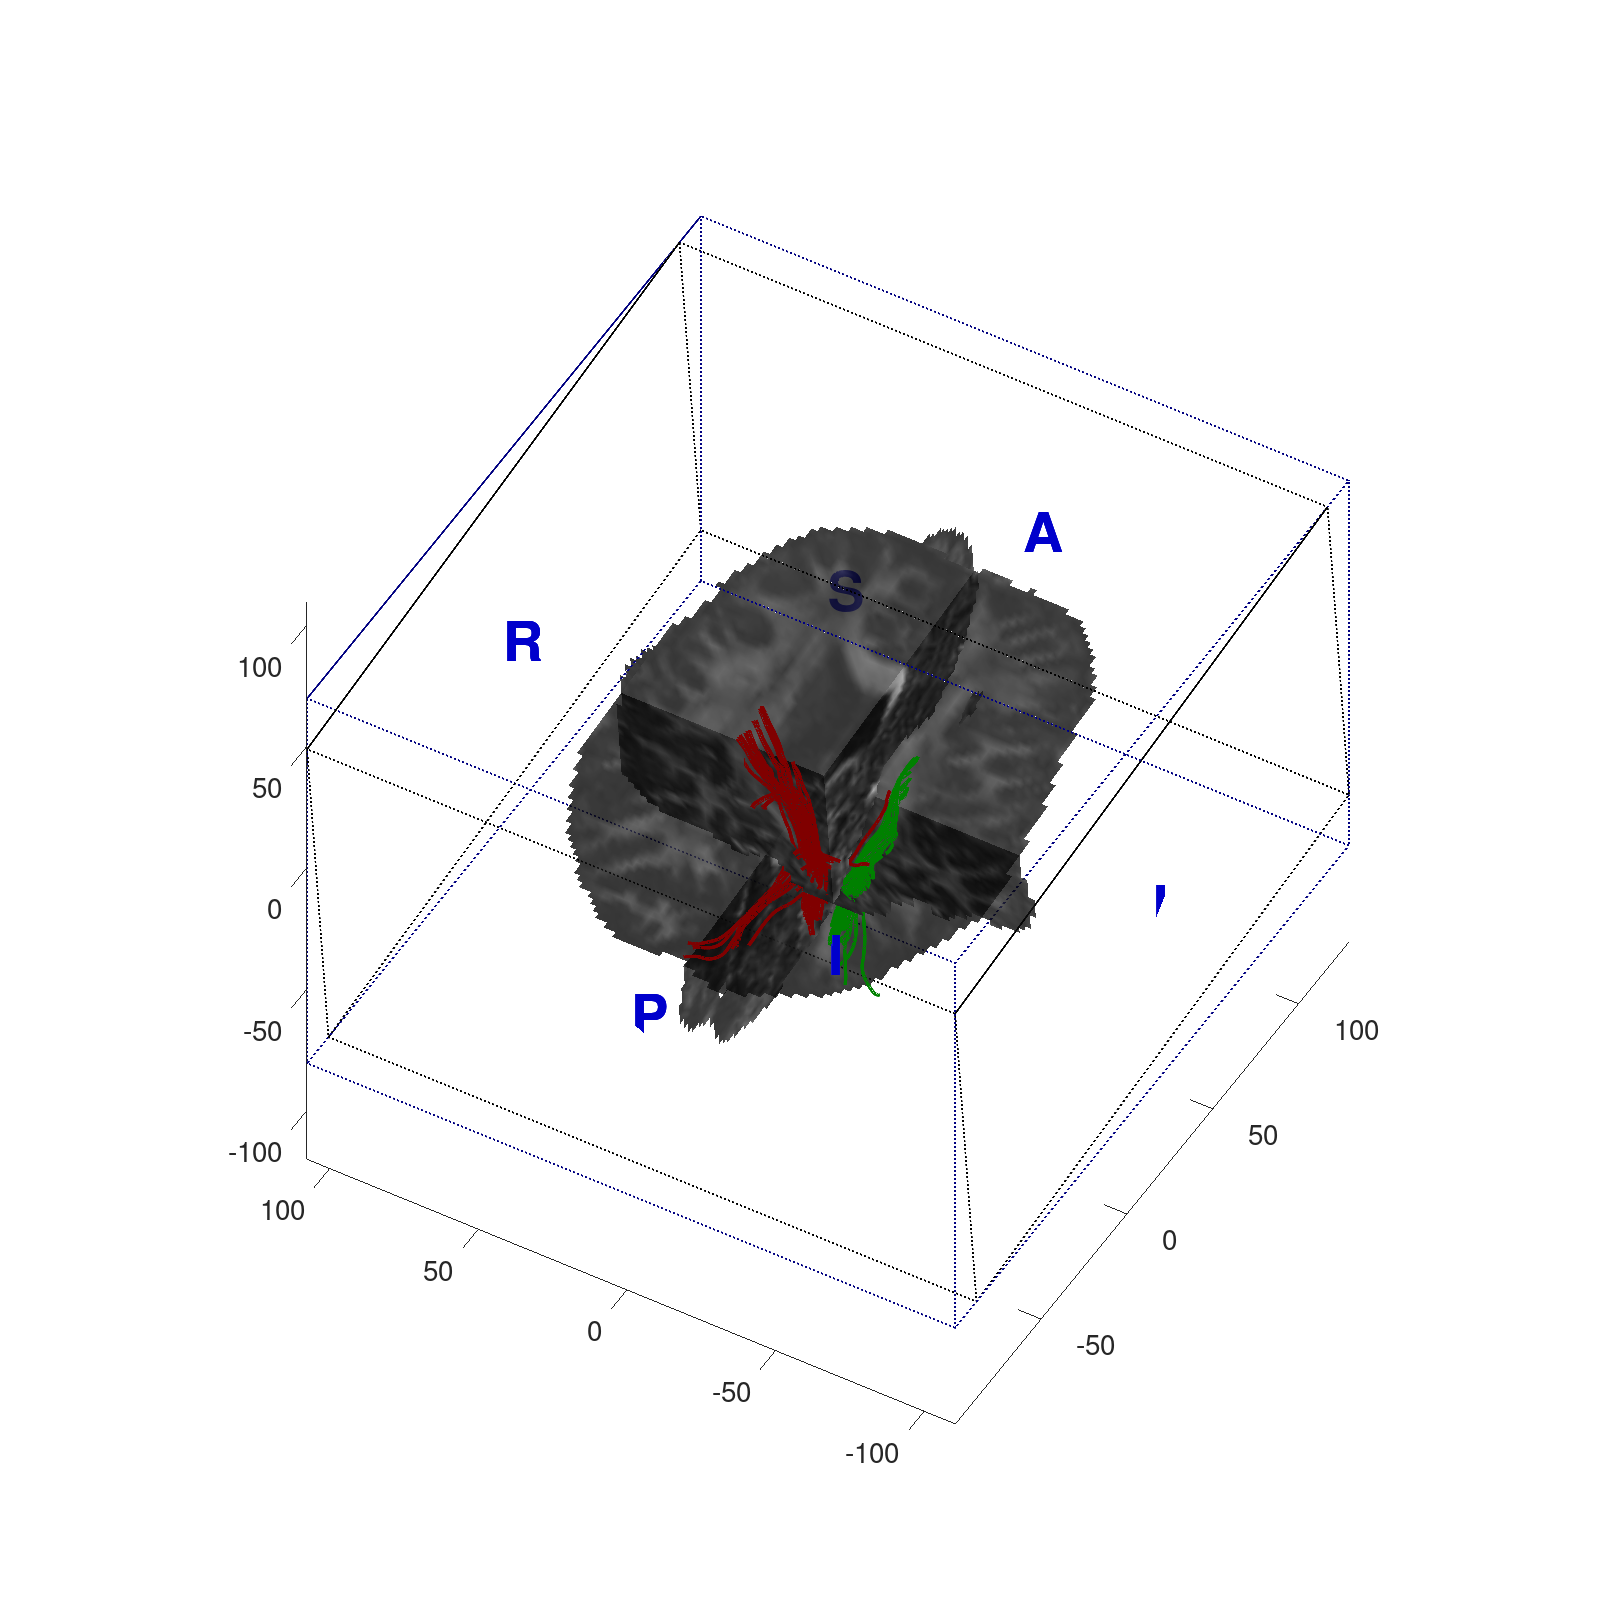

In [13]:
% Axial:
i1 = [1,szI];
j1 = [1,szJ];
k1 = [round(szK/2),round(szK/2)];
% Sagittal:
i2 = [round(szI/2),round(szI/2)];
j2 = [1,szJ];
k2 = [1,szK];
% Coronal:
i3 = [1,szI];
j3 = [round(szJ/2),round(szJ/2)];
k3 = [1,szK];
% Make the plots:
close(figure(4));
hf4 = figure(4);
set(hf4,'Position',[1,1,800,800]);
% Get the current axes of the newly created figure:
ha = axes(hf4);
for ax=1:3
    ix = eval(sprintf('i%d',ax));
    jx = eval(sprintf('j%d',ax));
    kx = eval(sprintf('k%d',ax));
    plotdmri3d( dtiSH, ix, jx, kx, ...
        'mask', mask, ...
        'origin', ijk2xyz(1:3,4), ...
        'direction', ijk2xyz(1:3,1:3), ...
        'space', 'RAS', ...
        'ha', ha, ...
        'glyphs', false, ...
        'bgimage', 'fa', ...
        'bgalpha', 0.8 ...
        );
end

% And now we are ready to actually plot the streamlines:

for n=1:length(paths1)
    streamline = paths1{n}; % Retriebe an entry of the cell array
    if(~isempty(streamline))
        % Empty streamlines can appear if something goes wrong
        plot3( ha, ... % Plot in the same previous axes
            streamline(1,:), ... % x
            streamline(2,:), ... % y
            streamline(3,:), ... % z
            'Color', [.5,.0,.0], ...
            'LineWidth', 2 );
    end
end
% Repeat for the other hemisphere:
for n=1:length(paths2)
    streamline = paths2{n}; % Retriebe an entry of the cell array
    if(~isempty(streamline))
        % Empty streamlines can appear if something goes wrong
        plot3( ha, ... % Plot in the same previous axes
            streamline(1,:), ... % x
            streamline(2,:), ... % y
            streamline(3,:), ... % z
            'Color', [.0,.5,.0], ...
            'LineWidth', 2 );
    end
end
% Scale the axis so that they represent real-world dimensions:
axis('equal');
% Rotate:
view(150,-45);
% Add some light effects to make things look cooler:
light
lighting(phong);
% Allow manual rotation (drag the mouse):
rotate3d('on');
drawnow;


***QUIZ:***

-  *Can you try to delineate the corpus callosum? (use label 5 of the labelmap) And the cingulum? (labels 3 and 4).*
-   *Can you make the algorithm trace the streamlines further than it currently does?*  ***HINT:*** *check the '<samp>threshold</samp>* *' argument of the* *<samp>dti2tractography</samp>* *function.*
<pre>
help dti2tractography
</pre>

[Go back to index page](./tour_00index.ipynb)


[Previous](./tour_05advanced.ipynb)
